In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo

# Ejemplo de multiclass

In [2]:
import os.path
if not os.path.exists('mlp_helper.py'):
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/mlp_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/fnn_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/MNIST_helper.py
    !wget https://github.com/lab-ml-itba/MLP-2019/raw/master/draw_nn.py

# MLP in MNIST database of handwritten digits <a class="tocSkip">
- MNIST (Modified National Institute of Standards and Technology database) 
- MPL (Multi-Layer Perceptron)

# Introducción
## Performance de distintos clasificadores 

Ver classifiers:

https://en.wikipedia.org/wiki/MNIST_database

## El MNIST dataset

- Surge de mezclar el NIST original (Test set y Train set eran de fuentes diferentes)
- Mas de 20 años de publicaciones al respecto
- Muy investigado y mucha documentación
- 60.000 imagenes en training y 10.000 en testing
- Todas las imagenes del mismo tamaño 28x28
- Ya preprocesadas
- En su publicación original en 2002 se utilizó SVM (Support Vector Machine) con una exactitud de 0.8

## Video recomendado:
[Tensorflow and deep learning, without a PhD](https://www.youtube.com/watch?v=vq2nnJ4g6N0)

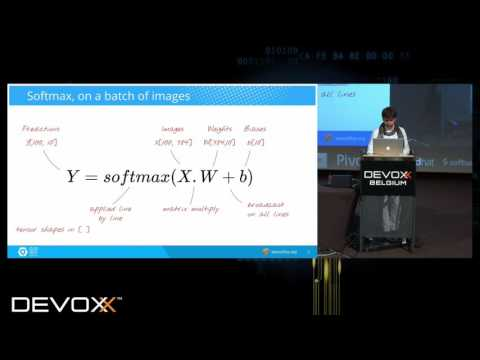

In [3]:
YouTubeVideo('vq2nnJ4g6N0')

# Importar y analizar dataset

In [4]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
import draw_nn

Using TensorFlow backend.


## Importo el dataset

In [5]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

In [6]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


## Grafico los 100 primeros dígitos

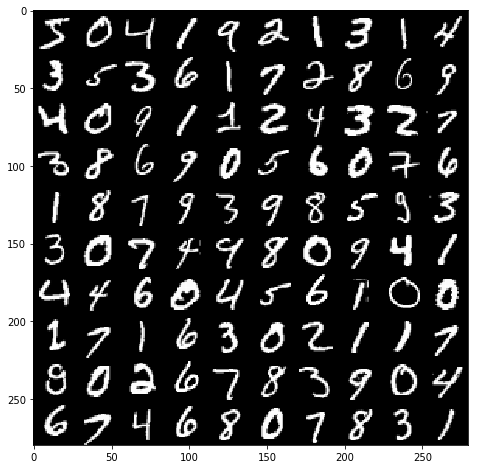

In [7]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

## Vizualizo un dígito en escala de grises

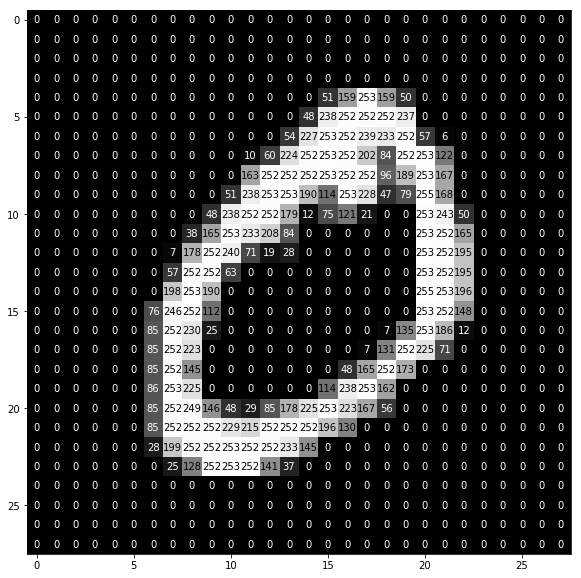

In [8]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[1], ax)
plt.show()

# Regresión logística multinomial

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

## Acomodo entrada

In [10]:
x_train_flattened = x_train.reshape(-1,784)
x_test_flattened = x_test.reshape(-1,784)

## Entreno clasificador

In [11]:
clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05)
clf_logistic.fit(x_train_flattened, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.05, verbose=0,
                   warm_start=False)

## Imprimo resultados

In [12]:
train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
print(train_score_logistic, test_score_logistic)

0.93 0.9252


# Red Neuronal de 1 Capa (Regresión Logística)

## Diagrama

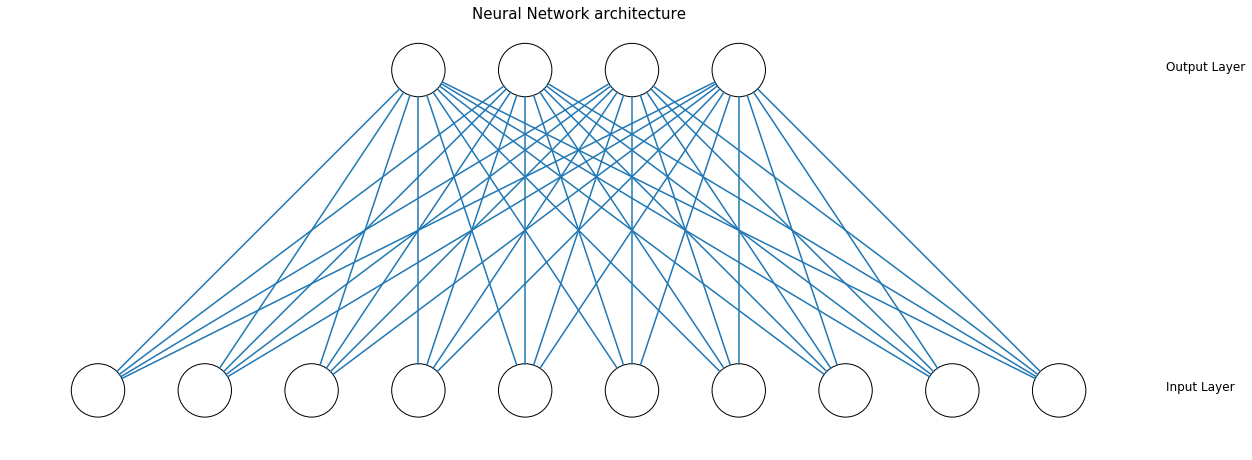

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [13]:
network = draw_nn.DrawNN( [10,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

In [14]:
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils

In [15]:
x_train.shape[1:]

(28, 28)

## Acomodo Salida: one-hot encoding

In [16]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[:5])

(48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Definimos el modelo

In [17]:
x_train.shape

(48000, 28, 28)

In [18]:
output_size = 10

# Creo el modelo
model_single_layer = Sequential()
model_single_layer.add(Flatten(input_shape=x_train.shape[1:])) # Esta capa es opcional, se podria haber hecho el flatten antes
model_single_layer.add(Dense(output_size, kernel_initializer='zeros', name='Salida'))
model_single_layer.add(Activation('softmax'))
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Compilamos el modelo
lr suele ser proporcional al mini-bath size. Es decir que si funciona con un lr y aumento el bs, deberia aumentar proporcionalmente el lr

In [19]:
# Compilo el modelo
lr = 0.00001 #0.01, 0.001, 0.00001, 0.000001, 0.00000001
#lr = 0.00000001
#lr = 0.01
SGD = optimizers.SGD(lr=lr, decay=1e-3)
model_single_layer.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])

## Preguntas y explicación de parametros

- ¿Por que tiene esa cantidad de parametros?

Capas ([Core Layers](https://keras.io/layers/core/)):
- Dense
- Flatten
- Activation

Parámetros:
- Learning Rate (lr)
- Funciones de activación ([Activations](https://keras.io/activations/)): Sigmoid, Relu, [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- Optimizers: [Keras](https://keras.io/optimizers/), [Articulo interesante](http://ruder.io/optimizing-gradient-descent/)
- Costo ([losses](https://keras.io/losses/))
- [Initializers](https://keras.io/initializers/)

## Exactitud del modelo sin entrenar
**¿Cuanto es de esperar?**

In [20]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.3025851249694824
accuracy:  0.098


## Defino Callbacks
(No son estrictamente necesarias)

In [21]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_val, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

## Entreno el modelo

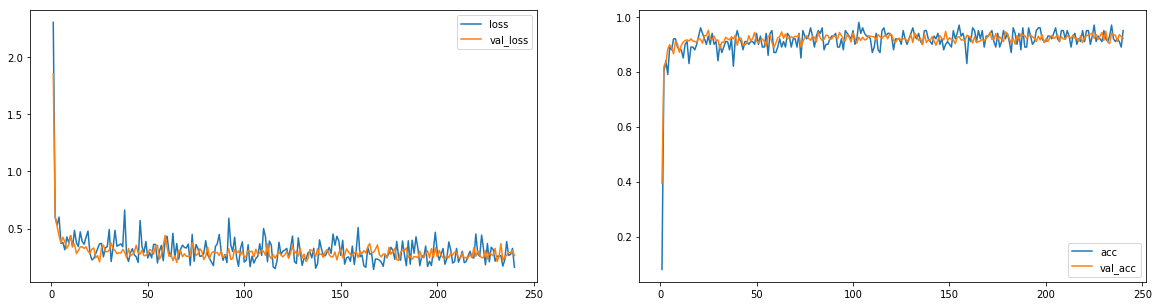


Epoch 00010: val_loss improved from 0.27958 to 0.27924, saving model to single-layer.mnist.hdf5


In [22]:
batch_size = 1000
batch_size = 100
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=10, batch_size=batch_size, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

**¿Por que val_loss y val_acc es menos ruidosa que loss y val?**

## Exactitud del modelo despues de entrenar

In [23]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.28078376054763793
accuracy:  0.9221


## Analisis de los pesos

In [24]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)

(784, 10)
[-1.3108335e-05  1.2415166e-05  7.9248948e-06 -1.1652939e-05
  2.0131297e-06  6.6988345e-05 -4.2943084e-06  2.5149475e-05
 -7.2644296e-05 -1.2791144e-05]


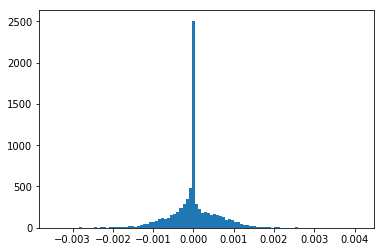

In [25]:
plt.hist(weights.flatten(), 100)
plt.show()

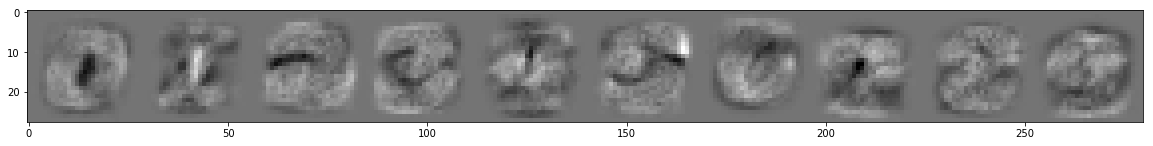

In [26]:
plt.figure(figsize=(20,20))
concatenated_weights = weights[:,0].reshape(28,28)
for wei in weights.T[1:10]:
    concatenated_weights = np.concatenate((concatenated_weights, wei.reshape(28,28)),axis=1 )
plt.imshow(concatenated_weights, cmap='gray')
plt.show()

## Analisis de dígitos errados

In [27]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [28]:
def get_sorted_errors(model):
    losses = []
    for i in range(len(x_test)):
        CE_loss = model.evaluate(x_test[i:i+1], y_test_categorical[i:i+1], verbose=0)[0]
        losses.append(CE_loss)
    predictions = model.predict(x_test)
    predicted_numbers = predictions.argmax(axis=1)
    sorted_loss_indexes = np.argsort(losses)[::-1]
    return predictions, predicted_numbers, sorted_loss_indexes

In [29]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model_single_layer)
print(predictions[:2])
print(predicted_numbers[:2])

[[3.65570522e-05 8.17311385e-10 9.18072692e-05 5.84340561e-03
  1.01343414e-06 1.31798433e-05 5.43695711e-09 9.93318319e-01
  6.90734523e-05 6.26587309e-04]
 [1.30721694e-03 1.22473775e-05 9.79296625e-01 1.51578884e-03
  1.50108797e-11 3.55340610e-03 1.30360043e-02 1.51320579e-13
  1.27882964e-03 8.20479629e-10]]
[7 2]


[(2, 7), (9, 2), (2, 6), (7, 2), (1, 5), (1, 2), (2, 4), (4, 0), (2, 4), (2, 7), (1, 3), (7, 2), (9, 0), (9, 0), (7, 1), (2, 9), (3, 8), (7, 8), (7, 2), (9, 5), (9, 0), (3, 9), (2, 6), (2, 8), (7, 2), (6, 5), (5, 8), (8, 4), (7, 1), (9, 3), (2, 7), (5, 0), (7, 1), (5, 6), (1, 2), (5, 0), (5, 6), (2, 6), (7, 2), (5, 8), (2, 9), (2, 9), (9, 0), (3, 7), (6, 0), (7, 2), (7, 2), (8, 7), (8, 3), (7, 3), (2, 3), (2, 8), (2, 6), (8, 4), (7, 2), (8, 4), (6, 1), (5, 1), (2, 0), (7, 2), (0, 3), (7, 8), (4, 8), (9, 3), (0, 7), (5, 2), (7, 3), (3, 5), (8, 0), (7, 2), (5, 2), (2, 3), (6, 0), (4, 2), (7, 9), (2, 4), (5, 4), (6, 0), (4, 2), (7, 2), (8, 6), (5, 6), (3, 6), (3, 8), (7, 9), (5, 4), (7, 4), (9, 1), (7, 1), (8, 5), (0, 8), (5, 6), (7, 2), (2, 9), (7, 2), (4, 2), (7, 2), (2, 0), (3, 9), (6, 2)]


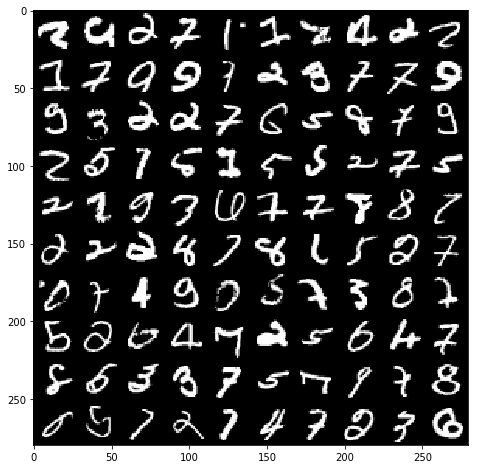

In [30]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

## Cargo pesos guardados
Los pesos fueron guardados con la clase ModelCheckpoint. Vamos a recuperarlos

In [31]:
# Cargo los valores del modelo
model_single_layer.load_weights('single-layer.mnist.hdf5')
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.28078376054763793
accuracy:  0.9221


# Red Neuronal de 2 capas

## Diagrama

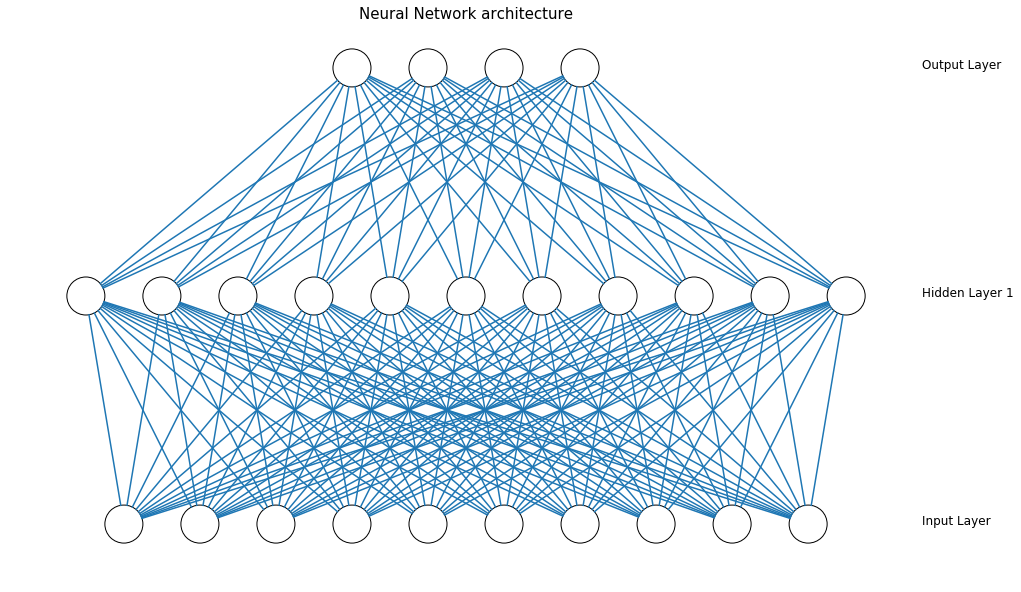

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [32]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

## Definición y compilación del modelo

In [33]:
def two_layer_model(lr=0.000001, decay=0):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='zeros', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


## Calculo de la cantidad de parámetros
**¿de donde sale la cantidad de parámetros?**

In [34]:
first_layer = 784*800+800
print(first_layer)
last_layer = 800*10 + 10
print(last_layer)
print(first_layer+last_layer)

628000
8010
636010


## Evaluación antes de entrenar

In [35]:
score_two_layers = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])

loss:  2.4625452072143554
accuracy:  0.0974


## Entrenamientos

### Learning rate = 0.01

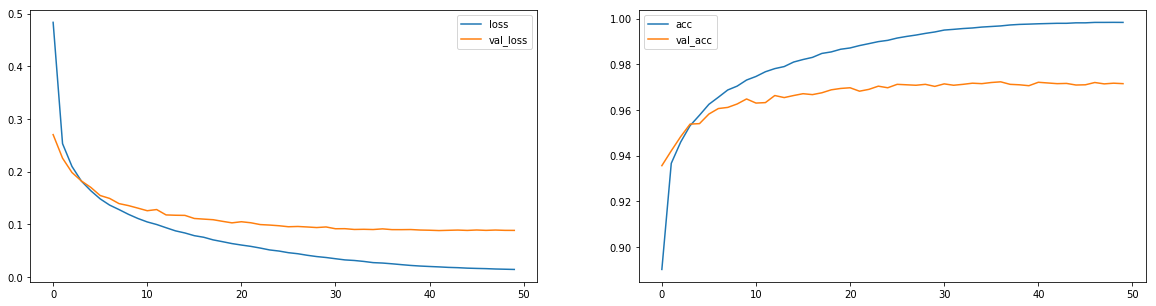


Epoch 00050: val_acc did not improve from 0.97230


In [36]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
checkpointer = ModelCheckpoint(filepath='two-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')

model_two_layers = two_layer_model(lr=0.01) # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [37]:
model_two_layers.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 2s 33us/step


[0.01343448577049033, 0.9984375]

In [38]:
model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 35us/step


[0.08819183764774352, 0.9715]

In [39]:
model_two_layers.load_weights('two-layer.mnist.hdf5')
model_two_layers.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 35us/step


[0.08963967226557433, 0.9723]

# Red Neuronal de 5 capas

## Activation: Relus
### Definición y compilación del modelo

In [109]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [110]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='five-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

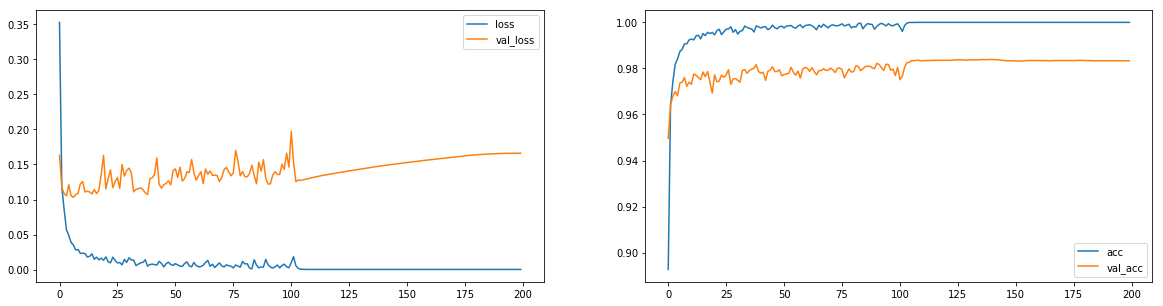


Epoch 00200: val_acc did not improve from 0.98390


In [111]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=200, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [112]:
model.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 2s 44us/step


[0.0003359128634276942, 0.9999791666666666]

In [113]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 44us/step


[0.16605366358173226, 0.9833]

In [114]:
model.load_weights('five-layer.mnist.hdf5')

In [115]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 45us/step


[0.14807935156968416, 0.9839]

### Resultados

In [116]:
predictions, predicted_numbers, sorted_loss_indexes = get_sorted_errors(model)

[(5, 8), (9, 3), (3, 7), (9, 4), (2, 7), (0, 7), (6, 4), (7, 0), (9, 1), (5, 8), (4, 9), (9, 2), (2, 6), (3, 2), (7, 2), (0, 4), (5, 0), (2, 8), (9, 1), (5, 6), (9, 5), (6, 1), (2, 8), (7, 2), (3, 8), (5, 3), (1, 2), (2, 1), (6, 0), (3, 8), (2, 6), (8, 3), (1, 6), (8, 7), (5, 3), (8, 7), (4, 6), (7, 2), (8, 0), (0, 6), (8, 9), (4, 2), (9, 5), (9, 5), (9, 4), (4, 9), (4, 9), (3, 5), (5, 3), (8, 7), (8, 1), (7, 0), (6, 0), (2, 8), (7, 2), (9, 8), (7, 3), (0, 8), (9, 0), (8, 5), (3, 5), (7, 2), (1, 0), (5, 8), (3, 7), (3, 8), (0, 6), (7, 9), (6, 1), (5, 7), (8, 2), (4, 9), (9, 5), (9, 1), (7, 0), (2, 3), (4, 9), (9, 8), (1, 6), (4, 9), (7, 1), (7, 2), (1, 2), (7, 9), (1, 5), (4, 9), (9, 5), (4, 9), (9, 7), (9, 4), (4, 9), (7, 9), (4, 9), (5, 4), (8, 2), (5, 9), (5, 6), (2, 3), (5, 7), (4, 9)]


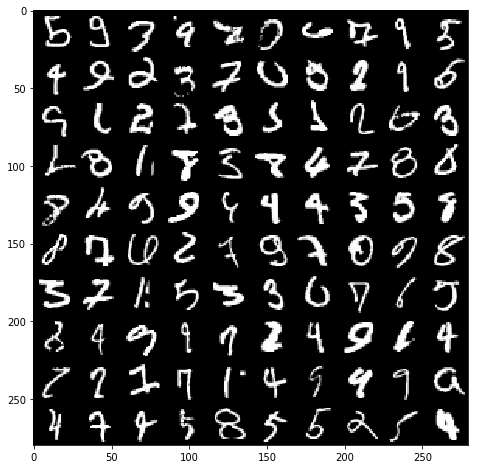

In [117]:
print(list(zip(y_test[sorted_loss_indexes[:100]], predicted_numbers[sorted_loss_indexes[:100]])))
plot_numbers(x_test, sorted_loss_indexes[:100], columns=10, figsize=(8, 8))

# Representación de los dígitos a la entrada de la Softmax

## Activation: Relus
### Definición y compilación del modelo

In [121]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(2, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 2)                 402       
_________________________________________________________________
salida (Dense)               (None, 10)                30        
Total params: 157,432
Trainable params: 157,432
Non-trainable params: 0
_________________________________________________________________


In [122]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
checkpointer = ModelCheckpoint(filepath='three-layer.mnist.hdf5', verbose=1, save_best_only=True, mode='max', monitor='val_acc')
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### Entrenamiento del modelo

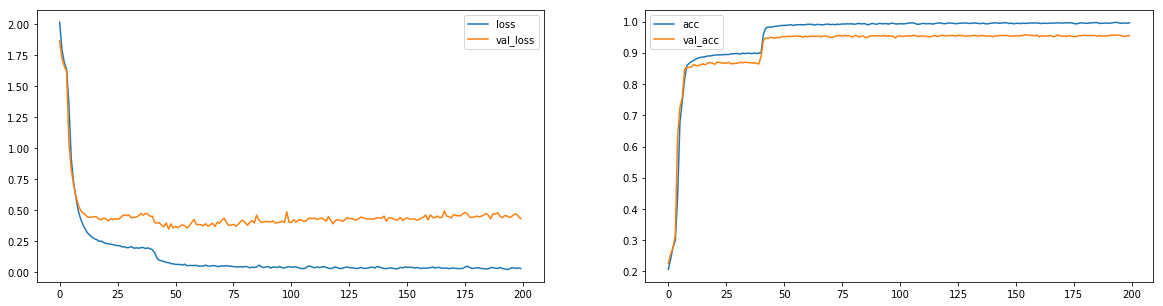


Epoch 00200: val_acc did not improve from 0.95740


In [123]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=200, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses, checkpointer],
         )

In [124]:
model.evaluate(x_train, y_train_categorical)

48000/48000 [==============================] - 2s 44us/step


[0.026408883011802876, 0.9959791666666666]

In [125]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 45us/step


[0.4287297861451283, 0.9547]

In [133]:
model.load_weights('three-layer.mnist.hdf5')

In [134]:
model.evaluate(x_test, y_test_categorical)

10000/10000 [==============================] - 0s 45us/step


[0.4188132877957076, 0.9574]

## Me quedo con el modelo hasta la anteúltima capa

In [135]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers[0:-1]]        # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

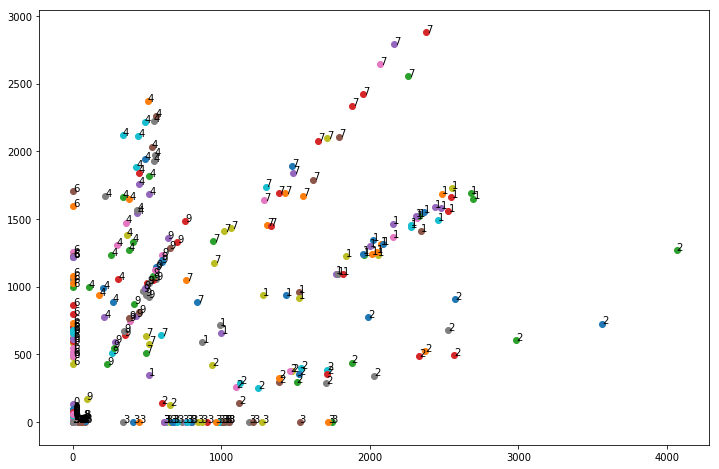

In [136]:
num_imgs=300
layer_outs = functor([x_train[0:num_imgs], 1.])
plt.figure(figsize=[12,8])
for idx,x in enumerate(layer_outs[2]):
    #print(idx)
    plt.text(x[0],x[1],str(y_train[idx]))
    plt.scatter(x[0],x[1])
plt.show()

In [77]:
list(layer_outs[4])

[array([1453.9443,    0.    ], dtype=float32),
 array([   0.    , 1405.5703], dtype=float32),
 array([2818.7358, 4300.338 ], dtype=float32),
 array([6092.3306, 2039.9314], dtype=float32),
 array([ 479.6537, 1357.0818], dtype=float32),
 array([2711.9446, 1706.5022], dtype=float32),
 array([6372.3623, 1916.4077], dtype=float32),
 array([4196.6104,  336.9055], dtype=float32),
 array([3845.9792, 1171.2258], dtype=float32),
 array([3613.612, 5834.645], dtype=float32)]

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros
- Se pierden las relaciones originales de los pixeles adyacentes (flatten). 